# Outlier Project  
[insert description]

## Import Libraries

In [61]:
import os
import glob
import re

from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt, floor

from scipy.stats import chi2

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

from joblib import Parallel, delayed

from xgboost import XGBClassifier

import json



## Functions and Utilities

In [2]:
def inject_fixed_mahalanobis_outliers(X:pd.DataFrame, y, contamination_rate=0.01, distance_k=6.0, outlier_flag=None, random_state=42):
    """
    Injects multivariate outliers at a fixed Mahalanobis distance `distance_k`
    from the original data distribution (as measured by mean/cov).
    
    Parameters
    ----------
    X : np.ndarray
        Feature matrix of shape (n_samples, n_features).
    y : np.ndarray
        Target vector of shape (n_samples,).
    contamination_rate : float
        Fraction of points to replace with outliers.
    distance_k : float
        Desired Mahalanobis distance.
    outler_flag : string (default = None)
        Name of column that flags outlier. function will change it to 1
    random_state : int or None
        Seed for reproducibility.
    
    Returns
    -------
    X_new, y_new : np.ndarray, np.ndarray
        New feature matrix and target vector with outliers injected.
    """
    rng = np.random.default_rng(random_state)

    X_new = X.copy()
    y_new = y.copy()

    if outlier_flag and (outlier_flag in X.columns):
        X= X.drop(columns=[outlier_flag])

    n_samples, n_features = X.shape
    num_outliers = int(np.ceil(n_samples * contamination_rate))
    
    if num_outliers == 0:
        return X, y
    
    # Compute mean and covariance of the original data
    mu = X.mean(axis=0).values
    cov = np.cov(X, rowvar=False)  # shape: (n_features, n_features)
    
    # Cholesky decomposition for the data's covariance
    U = np.linalg.cholesky(cov)  # shape: (n_features, n_features)

    # Generate random unit vectors in bulk
    y_rand = rng.normal(size=(num_outliers, n_features))
    y_normed = y_rand / np.linalg.norm(y_rand, axis=1, keepdims=True)
    z = distance_k * y_normed  # Each row is a z vector
    X_outliers = mu + (z @ U.T)  # Apply transformation to all at once
    
    #Randomize the outlier labels from existing distribution
    y_outliers = rng.choice(y, size=num_outliers)

    # Create DataFrame with original column names
    X_outliers = pd.DataFrame(X_outliers, columns=X.columns)
    
    # Randomly choose which points in X to replace
    indices_to_replace = rng.choice(n_samples, size=num_outliers, replace=False)
    
    if outlier_flag:
        X_outliers[outlier_flag] = 1
    X_new.iloc[indices_to_replace, :] = X_outliers.values
    y_new[indices_to_replace] = y_outliers

    return X_new, y_new

In [3]:
def parse_filename(filename):
    """
    Extracts (sample_size, contamination) from filenames like:
    'df100.csv' or 'df100_contam5.csv'.
    If the pattern doesn't match, returns (None, None).
    """
    pattern = r"df(\d+)(?:_contam(\d+))?\.csv"
    match = re.search(pattern, filename)
    if not match:
        return None, None
    sample_size = int(match.group(1))
    contam_str = match.group(2)
    contamination = int(contam_str) if contam_str else 0
    return sample_size, contamination

In [4]:
def mahalanobis_distance_sq(X):
    """
    Computes the squared Mahalanobis distance for each row in X.
    Returns an array of shape (n_samples,).
    """
    mu = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    # Center the data
    diff = X - mu
    # Mahalanobis distance^2 = (x - mu)^T * inv_cov * (x - mu)
    md_sq = np.diag(diff @ inv_cov @ diff.T)
    return md_sq

In [5]:
def mahalanobis_distance_sq_2d(X2):
    """
    Same as above, but specifically for a 2D array X2.
    """
    mu = np.mean(X2, axis=0)
    cov = np.cov(X2, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    diff = X2 - mu
    md_sq = np.diag(diff @ inv_cov @ diff.T)
    return md_sq

if os.path.isfile("results.csv"):
    existing_results_df = pd.read_csv("results.csv")
else:
    existing_results_df = pd.DataFrame()

In [6]:
def contaminate_dataset(X_df, y, c, distance_k=6.0, outlier_flag=None, random_state=42):
    """
    Injects synthetic multivariate outliers into a dataset at a fixed Mahalanobis distance,
    for a given contamination rate. Returns a new DataFrame containing the contaminated data.

    Parameters
    ----------
    X_df : pd.DataFrame
        Feature matrix including all relevant columns (e.g., 'fea_*', 'is_outlier').
    y : np.ndarray
        Target vector of shape (n_samples,), typically from the 'trgt' column.
    c : float
        Contamination rate, i.e., the fraction of points in X to replace with outliers.
    distance_k : float, default=6.0
        The fixed Mahalanobis distance of each injected outlier from the data mean.
    outlier_flag : str or None
        If specified, this column will be set to 1 for outlier rows.
    random_state : int, default=42
        Random seed for reproducibility.

    Returns
    -------
    c : float
        The same contamination rate used, useful for dictionary assignment.
    df_new : pd.DataFrame
        Contaminated version of X_df with outliers injected and target column reattached.
    """
    X_new, y_new = inject_fixed_mahalanobis_outliers(
        X_df, y,
        contamination_rate=c,
        distance_k=distance_k,
        outlier_flag=outlier_flag,
        random_state=random_state
    )

    df_new = X_new.copy()
    df_new["target"] = y_new
    return c, df_new

In [7]:
def generate_all_contaminated_datasets(original_data_dict, contamination_rates, distance_k=6.0, outlier_flag='is_outlier', random_state=42, n_jobs=-1):
    """
    Applies synthetic outlier injection across multiple datasets and contamination rates in parallel,
    returning a nested dictionary of contaminated datasets.

    Parameters
    ----------
    original_data_dict : dict
        Dictionary where keys are sample sizes (e.g., 100, 200) and values are pandas DataFrames.
        Each DataFrame should contain:
            - Feature columns prefixed with 'fea_'
            - Optional 'is_outlier' column
            - A target column named 'trgt'
    contamination_rates : list of float
        List of contamination rates to apply to each sample size.
    distance_k : float, default=6.0
        Mahalanobis distance to place injected outliers from the mean of the data distribution.
    outlier_flag : str or None, default='is_outlier'
        If specified, this column will be set to 1 for injected outliers.
    random_state : int, default=42
        Random seed for reproducibility.
    n_jobs : int, default=-1
        Number of parallel jobs to run. Use -1 to utilize all available CPU cores.

    Returns
    -------
    contaminated_data_dict : dict
        Nested dictionary of contaminated DataFrames structured as:
            {
                sample_size_1: {
                    contamination_rate_1: contaminated_df,
                    contamination_rate_2: contaminated_df,
                    ...
                },
                sample_size_2: {
                    ...
                },
                ...
            }
    """
    from joblib import Parallel, delayed

    contaminated_data_dict = {}

    for n, df in original_data_dict.items():
        # Split into features and target
        X_df = df.loc[:, df.columns.str.startswith('fea_') | (df.columns == outlier_flag)]
        y = df['trgt'].values

        results = Parallel(n_jobs=n_jobs)(
            delayed(contaminate_dataset)(X_df, y, c, distance_k=distance_k, outlier_flag=outlier_flag, random_state=random_state)
            for c in contamination_rates
        )

        contaminated_data_dict[n] = {c: df_new for c, df_new in results}

    return contaminated_data_dict

In [58]:
def plot_misclass_contamination(accuracy_summary, sample_size):
    """
    Plots misclassification rate versus contamination rate for different models 
    at a given sample size, using the accuracy summary dictionary.

    Parameters
    ----------
    accuracy_summary : dict
        A nested dictionary with structure:
        {
            model_name: {
                contamination_rate: {
                    sample_size_1: accuracy,
                    sample_size_2: accuracy,
                    ...
                    'summary': average_accuracy_across_sample_sizes
                },
                ...
            },
            ...
        }

    sample_size : int or str
        The specific sample size to visualize (e.g., 1000, 5000),
        or the string 'summary' to use the averaged accuracy across sample sizes.

    Behavior
    --------
    - For each model, it extracts accuracy at the given sample size for all contamination levels.
    - Converts accuracy to misclassification rate (1 - accuracy).
    - Sorts the contamination levels for consistent x-axis plotting.
    - Plots one line per model, showing misclassification rate vs. contamination rate.

    Notes
    -----
    - The x-axis represents contamination rates.
    - The y-axis represents misclassification rates.
    - The plot includes a legend identifying each model.

    Example
    -------
    plot_misclass_contamination(accuracy_summary, sample_size=1000)
    plot_misclass_contamination(accuracy_summary, sample_size="summary")
    """
    plt.figure(figsize=(10, 6))
    for model_name, contamination_dict in accuracy_summary.items():
        contamination_levels = []
        misclassification_rates = []

        for contamination, sample_acc_dict in contamination_dict.items():
            acc = sample_acc_dict.get(sample_size)
            contamination_levels.append(contamination)
            misclassification_rates.append(1 - acc)  # convert to misclassification

    # Sort contamination levels for consistent plotting
        sorted_pairs = sorted(zip(contamination_levels, misclassification_rates))
        sorted_contam, sorted_misclass = zip(*sorted_pairs)

        plt.plot(sorted_contam, sorted_misclass, marker='o', label=model_name)

    if sample_size == "summary":
        title_str = 'Misclassification Rate vs. Contamination by Model (averaged over sample sizes)'
    else:
        title_str = f"Misclassification Rate vs. Contamination by Model (n={sample_size})"
    plt.title(title_str)
    plt.xlabel('Contamination Rate')
    plt.ylabel('Misclassification Rate')
    plt.legend(title='Model')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
# We'll keep a global list to collect new results from each model
new_results_global = {}

# Single scoring dictionary (shared by all models)
scoring_dict = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'
}

In [9]:
sample_sizes = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
n_fea = 10
contamination_rates = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

## Constructing Datasets

In [10]:
n = max(sample_sizes)
df = pd.DataFrame({"fea_0":np.random.normal(0,1,n),
                   "fea_1":np.random.normal(0,1,n),
                   "fea_2":np.random.normal(0,1,n),
                   "fea_3":np.random.normal(0,1,n),
                   "fea_4":np.random.normal(0,1,n),})
df['fea_5'] = df['fea_1']*df['fea_2'] - 0.5*df['fea_0'] + np.random.lognormal(0,0.1,n)
df['fea_6'] = df['fea_3'] + df['fea_4'] + np.random.normal(0,0.1,n)
df['fea_7'] = df['fea_2']*np.exp(df['fea_4']) + np.random.normal(1,0.42)
df['fea_5'] = (df['fea_5'] - df['fea_5'].mean()) / df['fea_5'].std() # Z-score standardization
df['fea_6'] = (df['fea_6'] - df['fea_6'].mean()) / df['fea_6'].std() # Z-score standardization
df['fea_7'] = (df['fea_7'] - df['fea_7'].mean()) / df['fea_7'].std() # Z-score standardization

df['y_int'] = df['fea_0']**2 + np.abs(df['fea_2'])**1.5 + (np.abs(df['fea_4'])**0.8)*df['fea_6'] + df['fea_5'] + np.random.lognormal(0,0.25,n)
df['trgt'] = (df['y_int'] >= 1.1*df['y_int'].median()).astype(float)
df['is_outlier'] = 0
df.drop(columns=['y_int'], inplace=True)


In [11]:
df

,fea_0,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,trgt,is_outlier
0,-0.809803,0.036818,1.997220,-0.766073,0.963332,0.558053,-0.048837,2.066617,1.0,0
1,-1.499706,-1.148549,-0.024426,-1.779250,-0.768617,0.700004,-1.806722,0.014553,0.0,0
2,-0.042574,0.820437,1.546695,0.009974,0.977253,1.060963,0.606743,1.626950,1.0,0
3,1.384111,0.326713,-2.355259,-0.936070,-1.214753,-1.251392,-1.567193,-0.254501,1.0,0
4,-1.384257,-2.725274,0.517183,0.993678,0.237054,-0.663071,0.863298,0.275464,1.0,0
...,...,...,...,...,...,...,...,...,...,...
9995,1.239555,-0.593603,0.684366,-2.045089,1.118718,-0.925336,-0.733751,0.838577,0.0,0
9996,-0.182346,2.343821,-0.874272,0.222579,-1.291156,-1.715972,-0.723882,-0.075066,0.0,0
9997,-0.540521,1.299958,0.180713,-0.047856,0.124255,0.547132,-0.045516,0.099043,0.0,0
9998,-2.000223,0.232293,0.870380,1.727224,1.193769,1.162863,2.064692,1.142586,1.0,0


### Sample

In [12]:
sample_dict = {
    size: df.sample(n=size, random_state=42).reset_index(drop=True)
    for size in sample_sizes
}

In [13]:
sample_dict[500]

,fea_0,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,trgt,is_outlier
0,0.363849,2.520462,-0.530333,0.346346,1.146945,-1.481316,1.114149,-0.634322,0.0,0
1,0.455449,-0.017628,-0.428921,0.628269,0.423628,-0.170587,0.707292,-0.237354,0.0,0
2,-0.846003,0.597177,-0.676504,-1.067831,-0.827519,0.066039,-1.419967,-0.096717,0.0,0
3,0.543885,-1.953173,-0.628588,0.553681,-1.477091,0.764061,-0.754274,-0.037163,0.0,0
4,-0.313734,-0.210538,0.321486,0.147459,-0.476501,0.108330,-0.327119,0.097089,0.0,0
...,...,...,...,...,...,...,...,...,...,...
495,1.364042,-1.747068,0.256841,1.356607,0.084298,-0.931369,1.033721,0.128312,0.0,0
496,-0.573232,0.555026,-1.402049,-0.093693,-0.165833,-0.554170,-0.089045,-0.445744,1.0,0
497,0.040476,0.216601,0.216310,-0.601903,-2.379323,0.288561,-2.165344,0.026822,0.0,0
498,1.262130,0.808794,-2.174073,1.161435,0.681825,-2.121170,1.269232,-1.663082,1.0,0


## Contamination

In [14]:
contaminated_data_dict = {}


In [15]:
contaminated_data_dict = generate_all_contaminated_datasets(
    sample_dict,
    contamination_rates,
    distance_k=6.0,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [16]:
contaminated_data_dict[1000].keys()

dict_keys([0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

## Data Viz

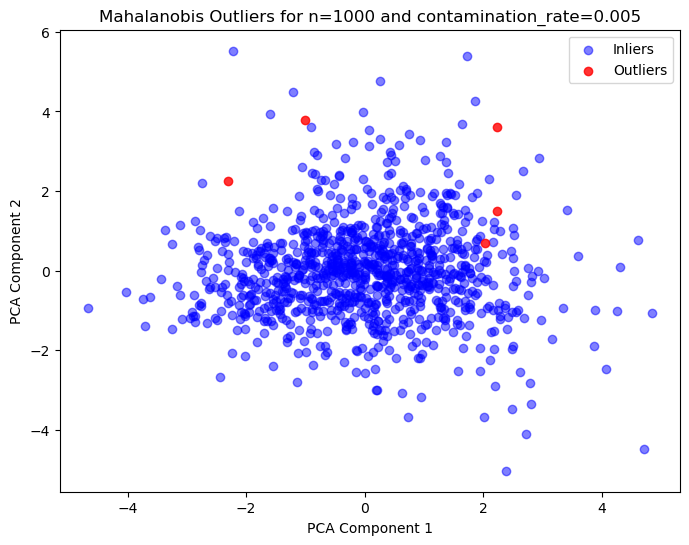

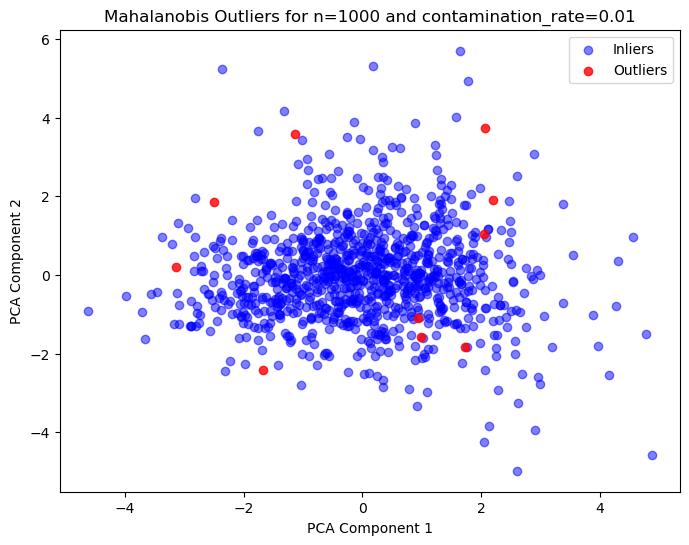

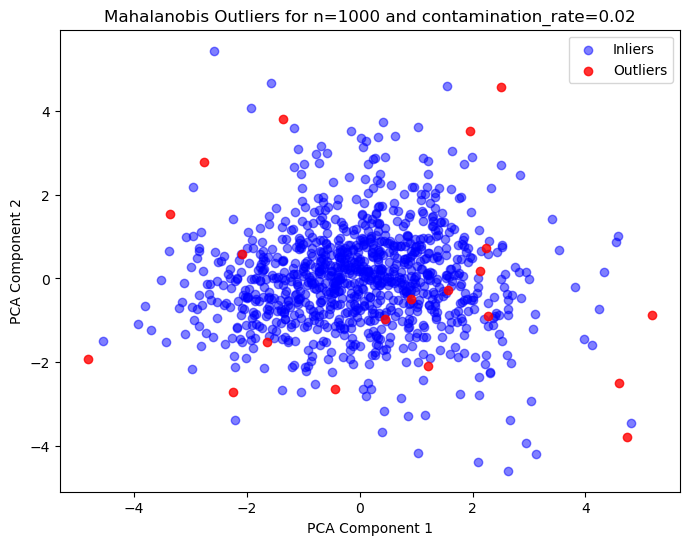

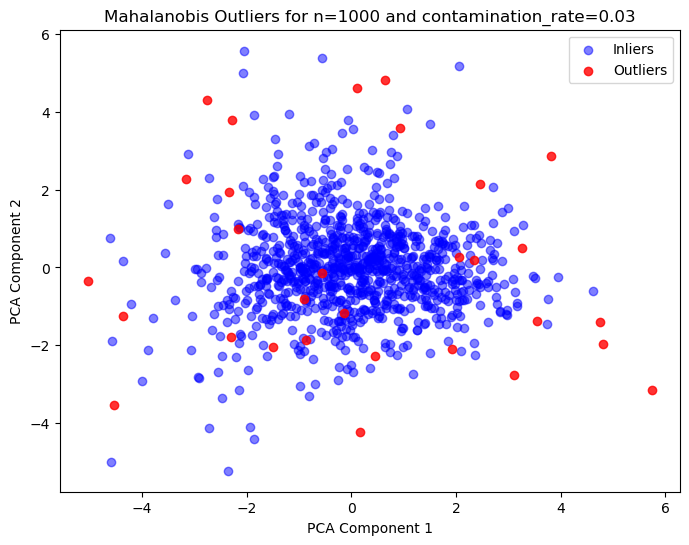

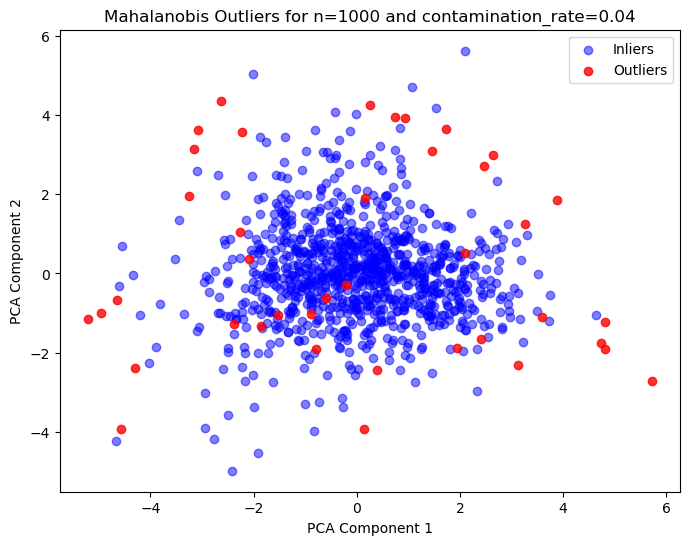

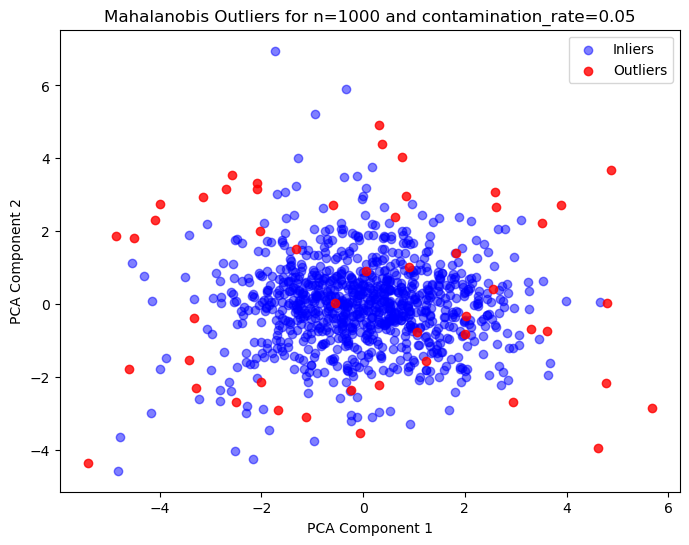

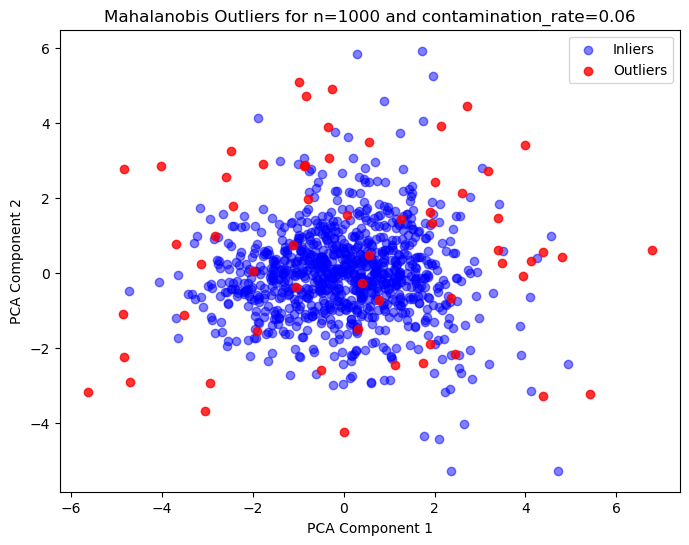

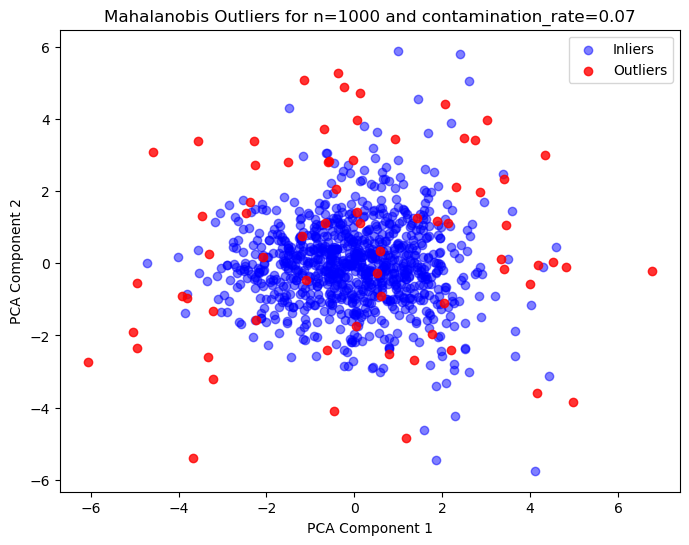

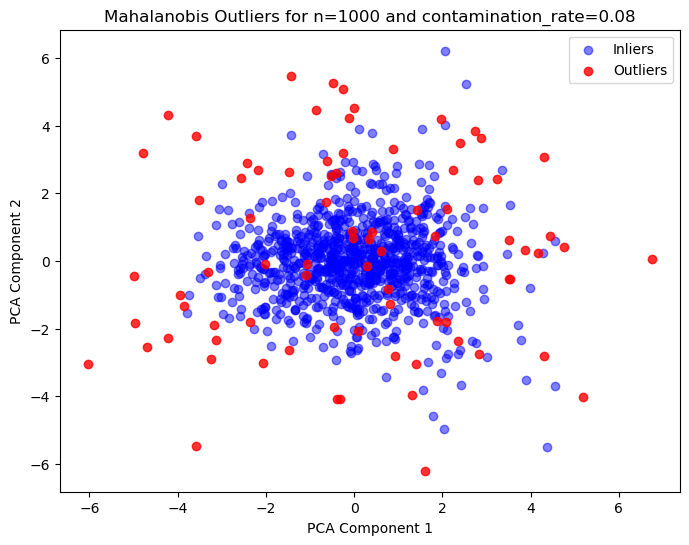

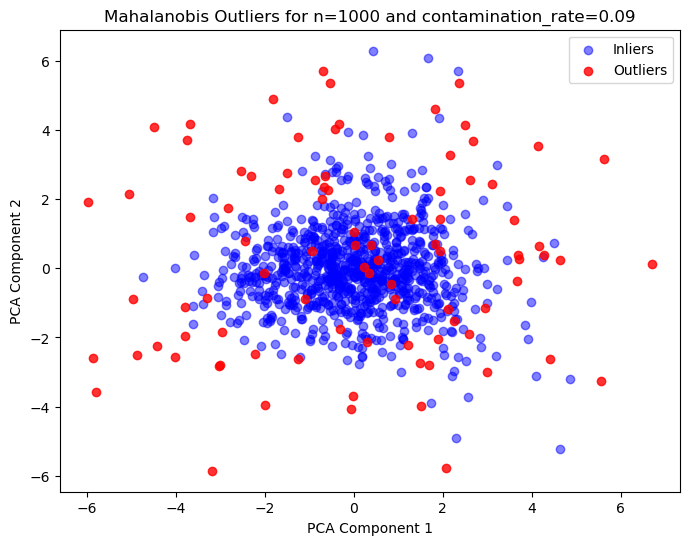

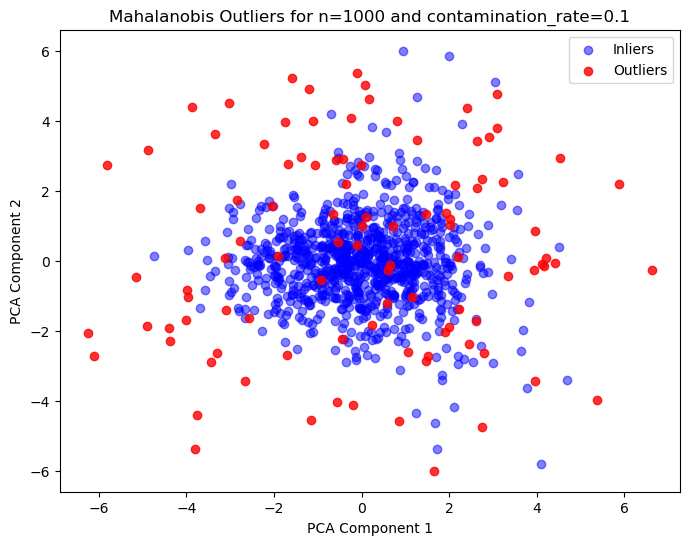

In [17]:
for sample_size, inner_dict in contaminated_data_dict.items():
    if sample_size == 1000:
        for contamination_rate, df in inner_dict.items():
            X = df.loc[:, df.columns.str.startswith('fea_')]
            outlier_mask = df['is_outlier']>0
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X)
            plt.figure(figsize=(8, 6))
            plt.title(f"Mahalanobis Outliers for n={sample_size} and contamination_rate={contamination_rate}")
            
            # Inliers in blue
            plt.scatter(
                X_pca[~outlier_mask, 0],
                X_pca[~outlier_mask, 1],
                c='blue', alpha=0.5, label='Inliers'
            )
            # Outliers in red
            plt.scatter(
                X_pca[outlier_mask, 0],
                X_pca[outlier_mask, 1],
                c='red', alpha=0.8, label='Outliers'
            )
    
            plt.legend()
            plt.xlabel("PCA Component 1")
            plt.ylabel("PCA Component 2")
            plt.show()

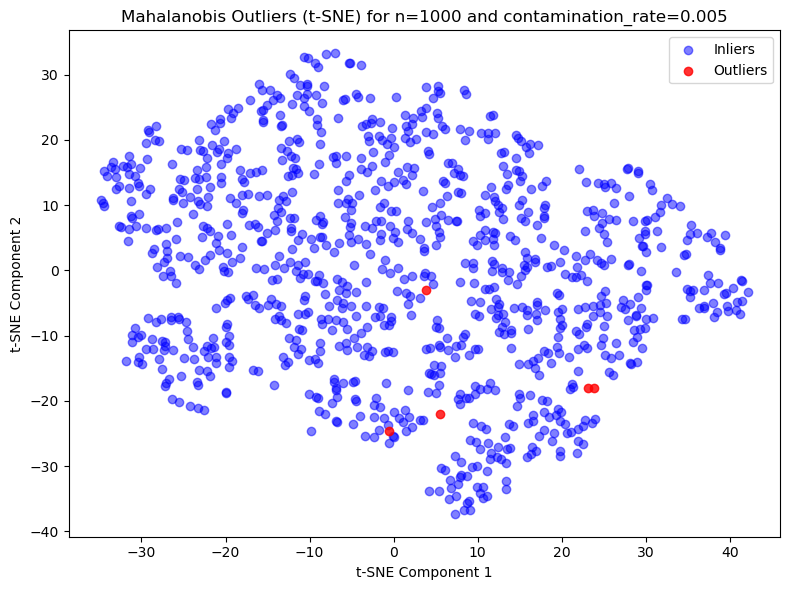

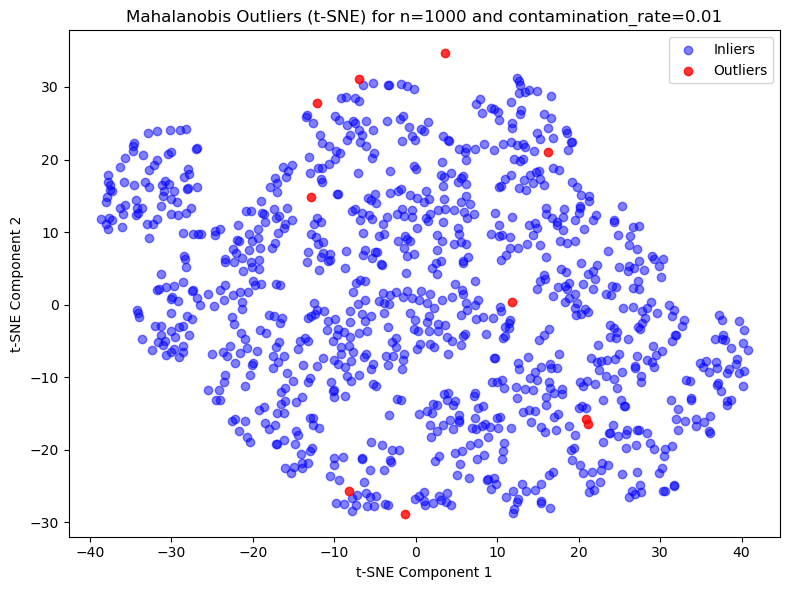

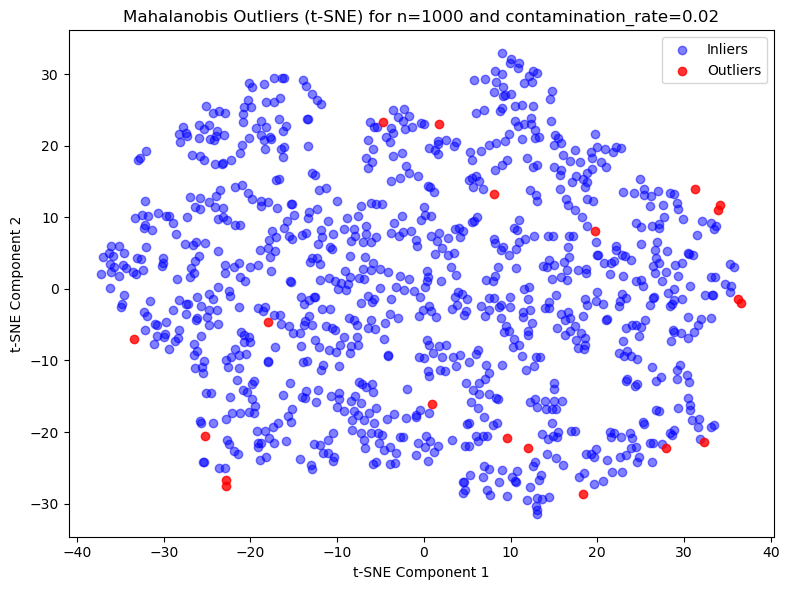

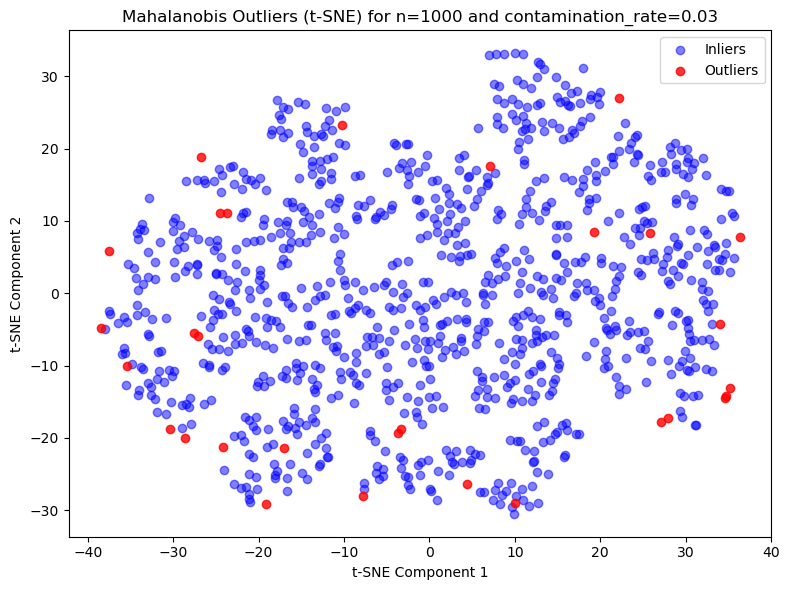

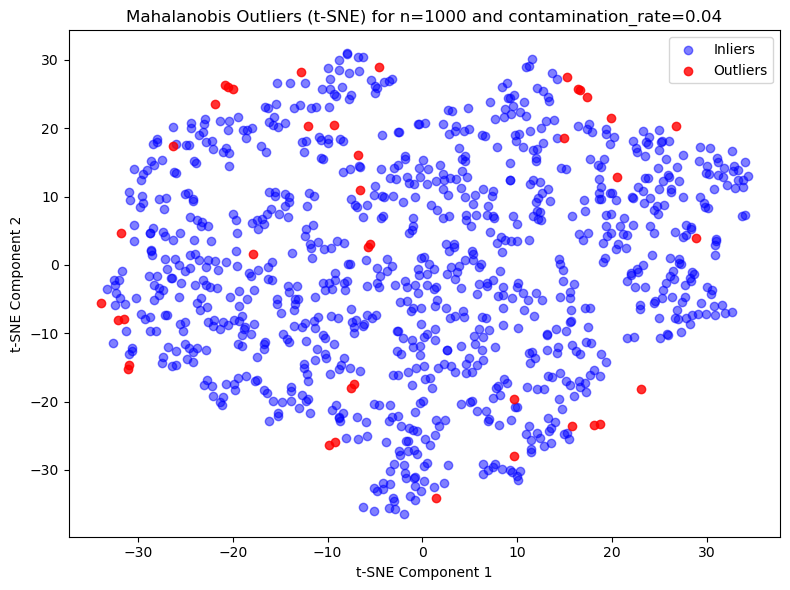

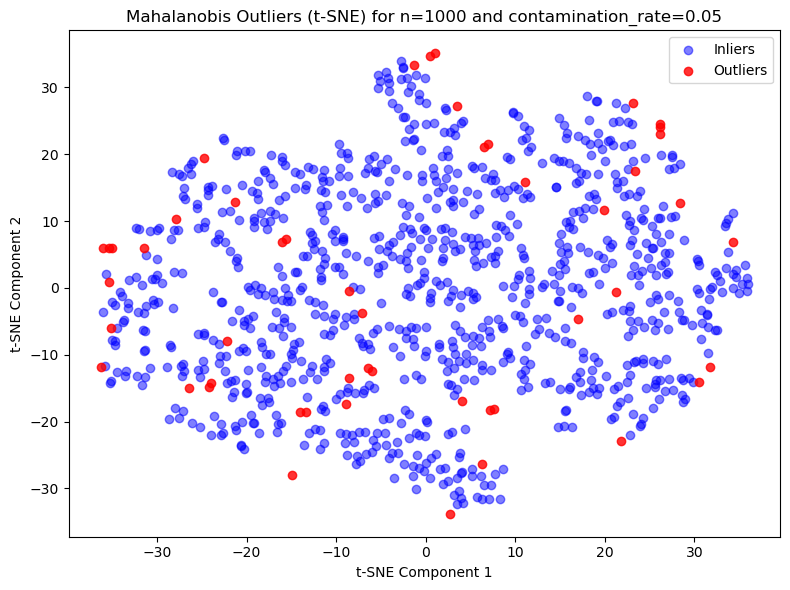

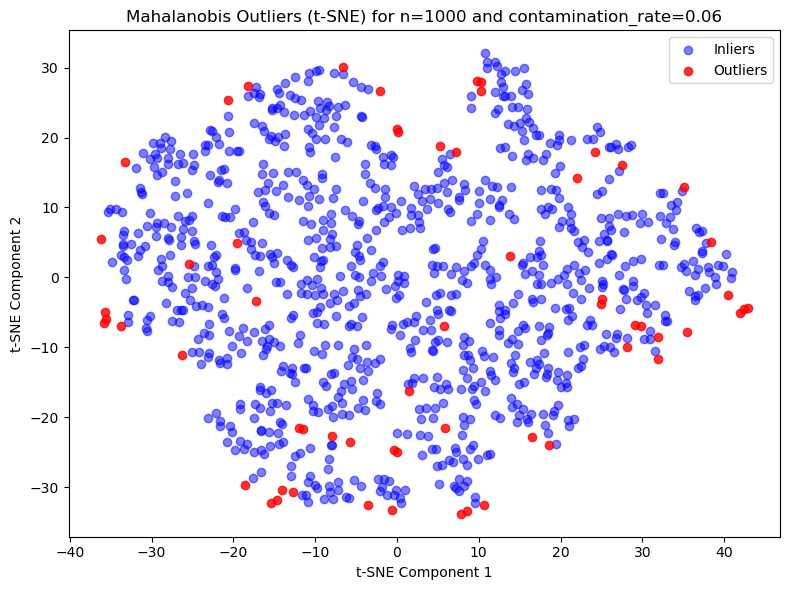

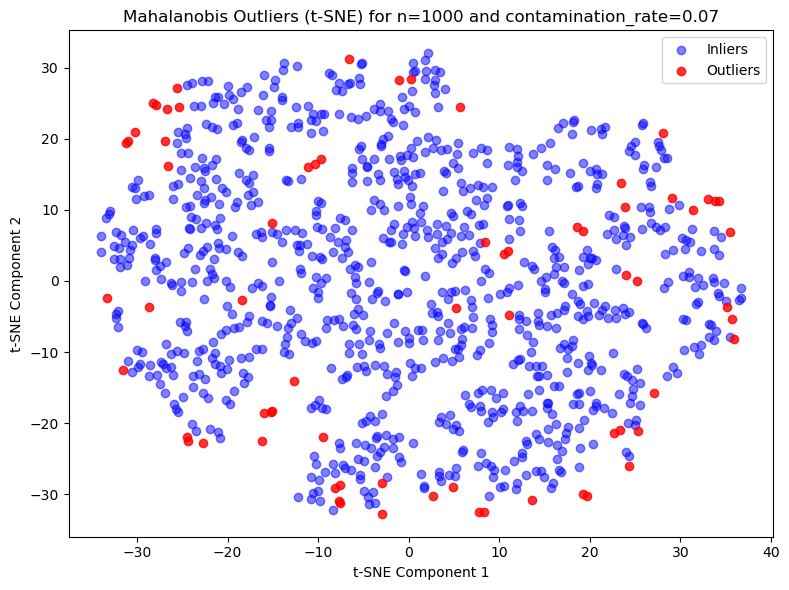

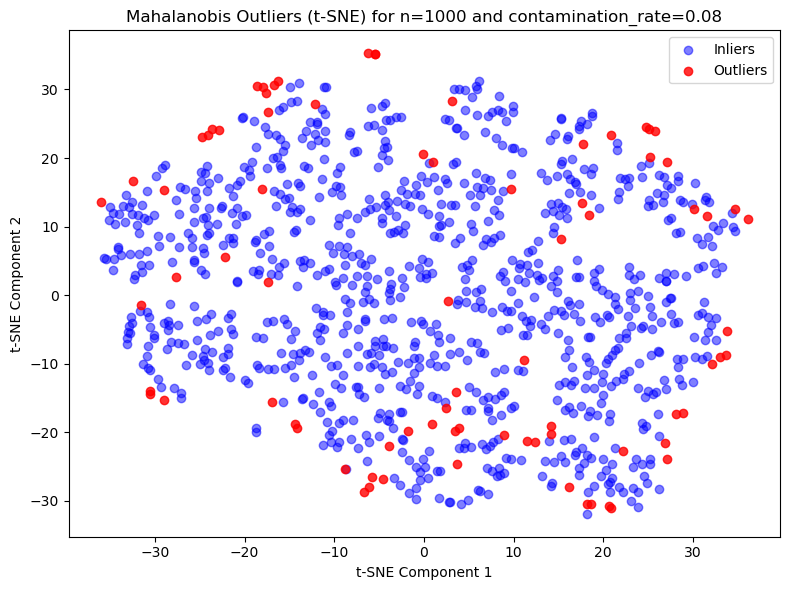

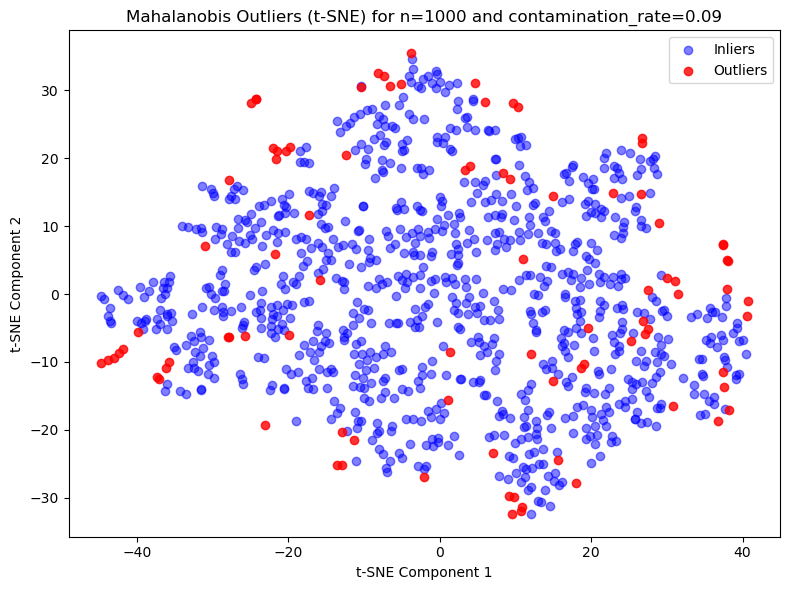

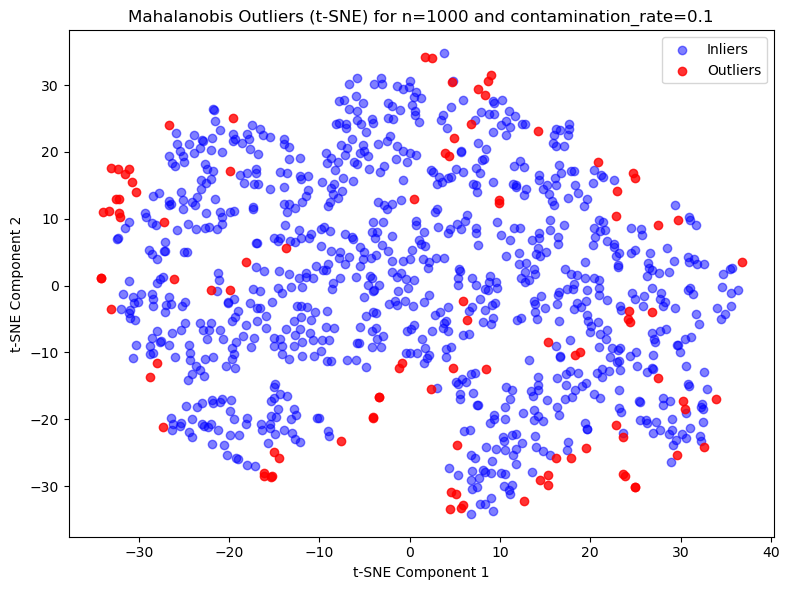

In [62]:
for sample_size, inner_dict in contaminated_data_dict.items():
    if sample_size == 1000:
        for contamination_rate, df in inner_dict.items():
            X = df.loc[:, df.columns.str.startswith('fea_')]
            outlier_mask = df['is_outlier'] > 0

            # Apply t-SNE
            tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
            X_tsne = tsne.fit_transform(X)

            plt.figure(figsize=(8, 6))
            plt.title(f"Mahalanobis Outliers (t-SNE) for n={sample_size} and contamination_rate={contamination_rate}")

            # Inliers in blue
            plt.scatter(
                X_tsne[~outlier_mask, 0],
                X_tsne[~outlier_mask, 1],
                c='blue', alpha=0.5, label='Inliers'
            )

            # Outliers in red
            plt.scatter(
                X_tsne[outlier_mask, 0],
                X_tsne[outlier_mask, 1],
                c='red', alpha=0.8, label='Outliers'
            )

            plt.legend()
            plt.xlabel("t-SNE Component 1")
            plt.ylabel("t-SNE Component 2")
            plt.tight_layout()
            plt.show()

## Modelling

### Test-Train Split

In [18]:
split_data_dict = {}

for sample_size, inner_dict in contaminated_data_dict.items():
    if sample_size not in split_data_dict:
        split_data_dict[sample_size] = {}
    for contamination_rate, df in inner_dict.items():
        if contamination_rate not in split_data_dict[sample_size]:
            split_data_dict[sample_size][contamination_rate] = {}
        X = df.loc[:, df.columns.str.startswith('fea_') | (df.columns == 'is_outlier')]
        y = df['target']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=0.2, 
            stratify= X['is_outlier'],
            random_state=42
            )
        X_train = X_train.drop(columns=['is_outlier'])
        X_test = X_test.drop(columns=['is_outlier'])
        split_data_dict[sample_size][contamination_rate]['X_train'] = X_train.copy()
        split_data_dict[sample_size][contamination_rate]['X_test'] = X_test.copy()
        split_data_dict[sample_size][contamination_rate]['y_train'] = y_train.copy()
        split_data_dict[sample_size][contamination_rate]['y_test'] = y_test.copy()

### XGBoost

In [25]:
new_results_xgb={}

In [26]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
for sample_size, inner_dict in split_data_dict.items():
    new_results_xgb[sample_size] = {}
    for contamination_rate, df_dict in inner_dict.items():
        X = df_dict['X_train']
        y = df_dict['y_train']
        X_test = df_dict['X_test']
        y_test = df_dict['y_test']
        # X = X.drop(columns=['is_outlier'])


        # Initialize XGBoost classifier
        xgb = XGBClassifier(eval_metric='logloss')

        # GridSearch with accuracy scoring
        grid_search = GridSearchCV(
            estimator=xgb,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            n_jobs=-1,
            verbose=0
        )

        # Train
        grid_search.fit(X, y)
        best_model = grid_search.best_estimator_

        # Evaluate
        y_pred = best_model.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Store results
        new_results_xgb[sample_size][contamination_rate] = {
            'best_params': grid_search.best_params_,
            'accuracy': test_acc,
            'classification_report': report,
            'model': best_model
        }

        print(f"✅ Done: sample_size={sample_size}, contamination={contamination_rate}, accuracy={test_acc:.4f}")



✅ Done: sample_size=500, contamination=0.005, accuracy=0.8500
✅ Done: sample_size=500, contamination=0.01, accuracy=0.8600
✅ Done: sample_size=500, contamination=0.02, accuracy=0.8000
✅ Done: sample_size=500, contamination=0.03, accuracy=0.8700
✅ Done: sample_size=500, contamination=0.04, accuracy=0.8600
✅ Done: sample_size=500, contamination=0.05, accuracy=0.8700
✅ Done: sample_size=500, contamination=0.06, accuracy=0.8000
✅ Done: sample_size=500, contamination=0.07, accuracy=0.9000
✅ Done: sample_size=500, contamination=0.08, accuracy=0.9000
✅ Done: sample_size=500, contamination=0.09, accuracy=0.8700
✅ Done: sample_size=500, contamination=0.1, accuracy=0.8700
✅ Done: sample_size=1000, contamination=0.005, accuracy=0.9050
✅ Done: sample_size=1000, contamination=0.01, accuracy=0.9150
✅ Done: sample_size=1000, contamination=0.02, accuracy=0.9150
✅ Done: sample_size=1000, contamination=0.03, accuracy=0.9000
✅ Done: sample_size=1000, contamination=0.04, accuracy=0.8800
✅ Done: sample_siz

### Random Forest

In [27]:
rf_results = {}

# Hyperparameter grid for Random Forest
param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2']
            }

In [28]:
for sample_size, inner_dict in split_data_dict.items():
    rf_results[sample_size] = {}

    for contamination_rate, df_dict in inner_dict.items():
        X = df_dict['X_train']
        y = df_dict['y_train']
        X_test = df_dict['X_test']
        y_test = df_dict['y_test']

        rf = RandomForestClassifier(random_state=42)

        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X, y)
        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        rf_results[sample_size][contamination_rate] = {
            'best_params': grid_search.best_params_,
            'accuracy': acc,
            'classification_report': report,
            'model': best_model
        }

        print(f"✅ RF done: sample_size={sample_size}, contamination={contamination_rate}, accuracy={acc:.4f}")

✅ RF done: sample_size=500, contamination=0.005, accuracy=0.8300
✅ RF done: sample_size=500, contamination=0.01, accuracy=0.8900
✅ RF done: sample_size=500, contamination=0.02, accuracy=0.8300
✅ RF done: sample_size=500, contamination=0.03, accuracy=0.8600
✅ RF done: sample_size=500, contamination=0.04, accuracy=0.8500
✅ RF done: sample_size=500, contamination=0.05, accuracy=0.8600
✅ RF done: sample_size=500, contamination=0.06, accuracy=0.8300
✅ RF done: sample_size=500, contamination=0.07, accuracy=0.8800
✅ RF done: sample_size=500, contamination=0.08, accuracy=0.9100
✅ RF done: sample_size=500, contamination=0.09, accuracy=0.8700
✅ RF done: sample_size=500, contamination=0.1, accuracy=0.8500
✅ RF done: sample_size=1000, contamination=0.005, accuracy=0.8900
✅ RF done: sample_size=1000, contamination=0.01, accuracy=0.8850
✅ RF done: sample_size=1000, contamination=0.02, accuracy=0.9200
✅ RF done: sample_size=1000, contamination=0.03, accuracy=0.9000
✅ RF done: sample_size=1000, contam

### Logistic Regression

In [29]:
logreg_results = {}

# Hyperparameter grid for Logistic Regression
param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],        # Regularization strength (inverse)
            'penalty': ['l2'],                   # Regularization type (L2 is standard)
            'solver': ['lbfgs'],                 # Works well for binary/multiclass
            'max_iter': [100, 200, 500]
            }


In [30]:
for sample_size, inner_dict in split_data_dict.items():
    logreg_results[sample_size] = {}

    for contamination_rate, df_dict in inner_dict.items():
        X = df_dict['X_train']
        y = df_dict['y_train']
        X_test = df_dict['X_test']
        y_test = df_dict['y_test']


        lr = LogisticRegression(random_state=42)

        grid_search = GridSearchCV(
            estimator=lr,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X, y)
        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        logreg_results[sample_size][contamination_rate] = {
            'best_params': grid_search.best_params_,
            'accuracy': acc,
            'classification_report': report,
            'model': best_model
        }

        print(f"✅ LogReg done: sample_size={sample_size}, contamination={contamination_rate}, accuracy={acc:.4f}")

✅ LogReg done: sample_size=500, contamination=0.005, accuracy=0.6600
✅ LogReg done: sample_size=500, contamination=0.01, accuracy=0.6700
✅ LogReg done: sample_size=500, contamination=0.02, accuracy=0.6200
✅ LogReg done: sample_size=500, contamination=0.03, accuracy=0.7200
✅ LogReg done: sample_size=500, contamination=0.04, accuracy=0.6500
✅ LogReg done: sample_size=500, contamination=0.05, accuracy=0.7200
✅ LogReg done: sample_size=500, contamination=0.06, accuracy=0.7200
✅ LogReg done: sample_size=500, contamination=0.07, accuracy=0.6700
✅ LogReg done: sample_size=500, contamination=0.08, accuracy=0.7300
✅ LogReg done: sample_size=500, contamination=0.09, accuracy=0.7400
✅ LogReg done: sample_size=500, contamination=0.1, accuracy=0.6800
✅ LogReg done: sample_size=1000, contamination=0.005, accuracy=0.6800
✅ LogReg done: sample_size=1000, contamination=0.01, accuracy=0.7750
✅ LogReg done: sample_size=1000, contamination=0.02, accuracy=0.7300
✅ LogReg done: sample_size=1000, contaminati

### SVM

In [31]:
svm_results = {}

# Define hyperparameter grid for both linear and RBF kernels
param_grid = [
            {
                'kernel': ['linear'],
                'C': [0.1, 1, 10]
            },
            {
                'kernel': ['rbf'],
                'C': [0.1, 1, 10],
                'gamma': ['scale', 'auto', 0.01, 0.1]
            }
        ]


In [32]:
for sample_size, inner_dict in split_data_dict.items():
    svm_results[sample_size] = {}

    for contamination_rate, df_dict in inner_dict.items():
        X = df_dict['X_train']
        y = df_dict['y_train']
        X_test = df_dict['X_test']
        y_test = df_dict['y_test']

        # Initialize SVM classifier
        svc = SVC()

        # Grid search with accuracy scoring
        grid_search = GridSearchCV(
            estimator=svc,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            n_jobs=-1,
            verbose=0
        )

        # Train model
        grid_search.fit(X, y)
        best_model = grid_search.best_estimator_

        # Evaluate
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Save results
        svm_results[sample_size][contamination_rate] = {
            'best_params': grid_search.best_params_,
            'accuracy': acc,
            'classification_report': report,
            'model': best_model
        }

        print(f"✅ SVM done: sample_size={sample_size}, contamination={contamination_rate}, "
              f"kernel={grid_search.best_params_['kernel']}, accuracy={acc:.4f}")

✅ SVM done: sample_size=500, contamination=0.005, kernel=rbf, accuracy=0.8600
✅ SVM done: sample_size=500, contamination=0.01, kernel=rbf, accuracy=0.9000
✅ SVM done: sample_size=500, contamination=0.02, kernel=rbf, accuracy=0.8200
✅ SVM done: sample_size=500, contamination=0.03, kernel=rbf, accuracy=0.9100
✅ SVM done: sample_size=500, contamination=0.04, kernel=rbf, accuracy=0.8900
✅ SVM done: sample_size=500, contamination=0.05, kernel=rbf, accuracy=0.8900
✅ SVM done: sample_size=500, contamination=0.06, kernel=rbf, accuracy=0.8900
✅ SVM done: sample_size=500, contamination=0.07, kernel=rbf, accuracy=0.8600
✅ SVM done: sample_size=500, contamination=0.08, kernel=rbf, accuracy=0.9300
✅ SVM done: sample_size=500, contamination=0.09, kernel=rbf, accuracy=0.8400
✅ SVM done: sample_size=500, contamination=0.1, kernel=rbf, accuracy=0.9100
✅ SVM done: sample_size=1000, contamination=0.005, kernel=rbf, accuracy=0.9300
✅ SVM done: sample_size=1000, contamination=0.01, kernel=rbf, accuracy=0.9

### KNN

In [45]:
knn_results = {}

In [46]:
for sample_size, inner_dict in split_data_dict.items():
    knn_results[sample_size] = {}

    for contamination_rate, df_dict in inner_dict.items():
        X = df_dict['X_train']
        y = df_dict['y_train']
        X_test = df_dict['X_test']
        y_test = df_dict['y_test']

        knn = KNeighborsClassifier()

        param_grid = {
            'n_neighbors': [k*4 for k in range(1,
                                               round(
                                                   sqrt(len(X))/4+1
                                               ))],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }

        grid_search = GridSearchCV(
            estimator=knn,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            n_jobs=-1
        )

        grid_search.fit(X, y)
        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        knn_results[sample_size][contamination_rate] = {
            'best_params': grid_search.best_params_,
            'accuracy': acc,
            'classification_report': report,
            'model': best_model
        }

        print(f"✅ KNN done: sample_size={sample_size}, contamination={contamination_rate}, accuracy={acc:.4f}")

✅ KNN done: sample_size=500, contamination=0.005, accuracy=0.8200
✅ KNN done: sample_size=500, contamination=0.01, accuracy=0.8600
✅ KNN done: sample_size=500, contamination=0.02, accuracy=0.7200
✅ KNN done: sample_size=500, contamination=0.03, accuracy=0.7900
✅ KNN done: sample_size=500, contamination=0.04, accuracy=0.8100
✅ KNN done: sample_size=500, contamination=0.05, accuracy=0.8600
✅ KNN done: sample_size=500, contamination=0.06, accuracy=0.8000
✅ KNN done: sample_size=500, contamination=0.07, accuracy=0.8000
✅ KNN done: sample_size=500, contamination=0.08, accuracy=0.8500
✅ KNN done: sample_size=500, contamination=0.09, accuracy=0.8600
✅ KNN done: sample_size=500, contamination=0.1, accuracy=0.7800
✅ KNN done: sample_size=1000, contamination=0.005, accuracy=0.8700
✅ KNN done: sample_size=1000, contamination=0.01, accuracy=0.8400
✅ KNN done: sample_size=1000, contamination=0.02, accuracy=0.8700
✅ KNN done: sample_size=1000, contamination=0.03, accuracy=0.8650
✅ KNN done: sample_s

## Results

In [47]:
new_results_global['xgboost'] = new_results_xgb
new_results_global['randomForest'] = rf_results
new_results_global['SVM'] = svm_results
new_results_global['logReg'] = logreg_results
new_results_global['KNN'] = knn_results

accuracy_summary = defaultdict(lambda: defaultdict(dict))

In [48]:
for model, inner_dict in new_results_global.items():

    for sample_size, inner_dict in inner_dict.items():

        for contamination_rate, results in inner_dict.items():
            accuracy_summary[model][contamination_rate][sample_size] = results['accuracy']

for model, inner_dict in accuracy_summary.items():
    for contamination_rate, inner_dict in inner_dict.items():
        accu_sum = 0
        for sample_size, accuracy in inner_dict.items():
            accu_sum += accuracy_summary[model][contamination_rate][sample_size]

        accuracy_summary[model][contamination_rate]['summary'] = accu_sum/ len(sample_sizes)

In [49]:
accuracy_summary_df = {}
for model, contamination_dict in accuracy_summary.items():
    data = {}

    # Collect all sample sizes including 'mean_accuracy'
    all_sample_sizes = set()
    for contamination_rate in contamination_dict:
        all_sample_sizes.update(contamination_dict[contamination_rate].keys())

    # Build rows: one per sample_size or 'mean_accuracy'
    for sample_size in all_sample_sizes:
        row = {}
        for contamination_rate in contamination_dict:
            if sample_size in contamination_dict[contamination_rate]:
                row[contamination_rate] = contamination_dict[contamination_rate][sample_size]
        data[sample_size] = row

    # Convert to DataFrame
    df = pd.DataFrame.from_dict(data, orient='index')
    df.index.name = 'Sample Size / Summary'
    accuracy_summary_df[model] = df

# Save to Excel (each model = one sheet)
with pd.ExcelWriter("accuracy_summary.xlsx") as writer:
    for model_name, df in accuracy_summary_df.items():
        df.to_excel(writer, sheet_name=model_name)

In [50]:
with open("accuracy_summary.json", "w") as f:
    json.dump(accuracy_summary, f, indent=4)

### Result Plots

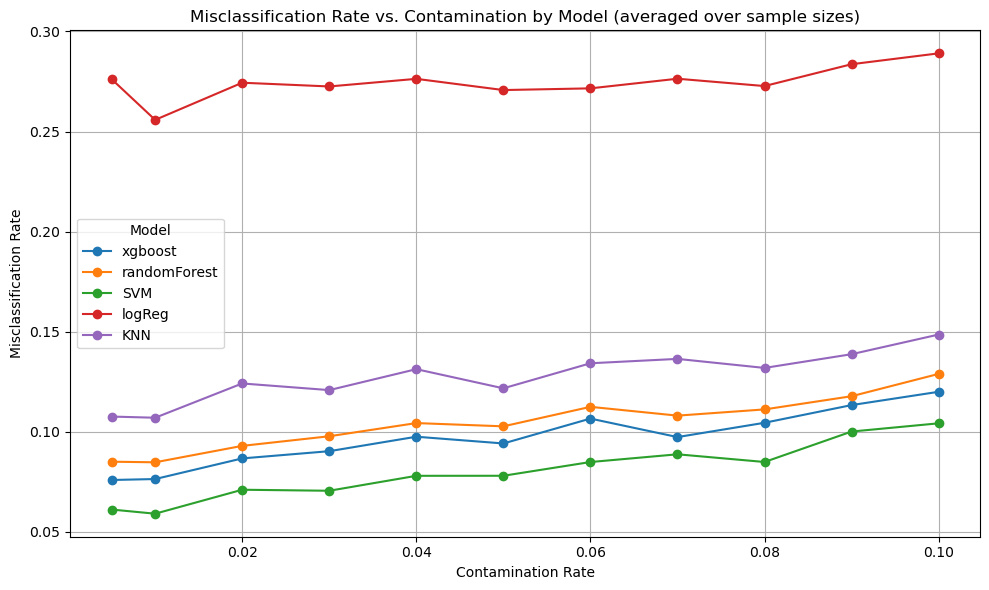

In [59]:
plot_misclass_contamination(accuracy_summary, "summary")

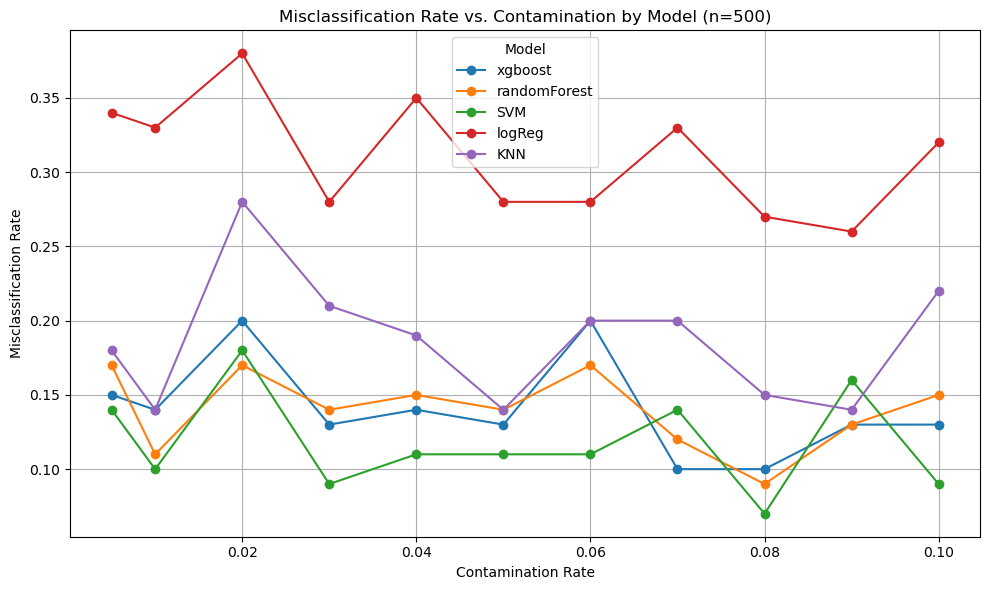

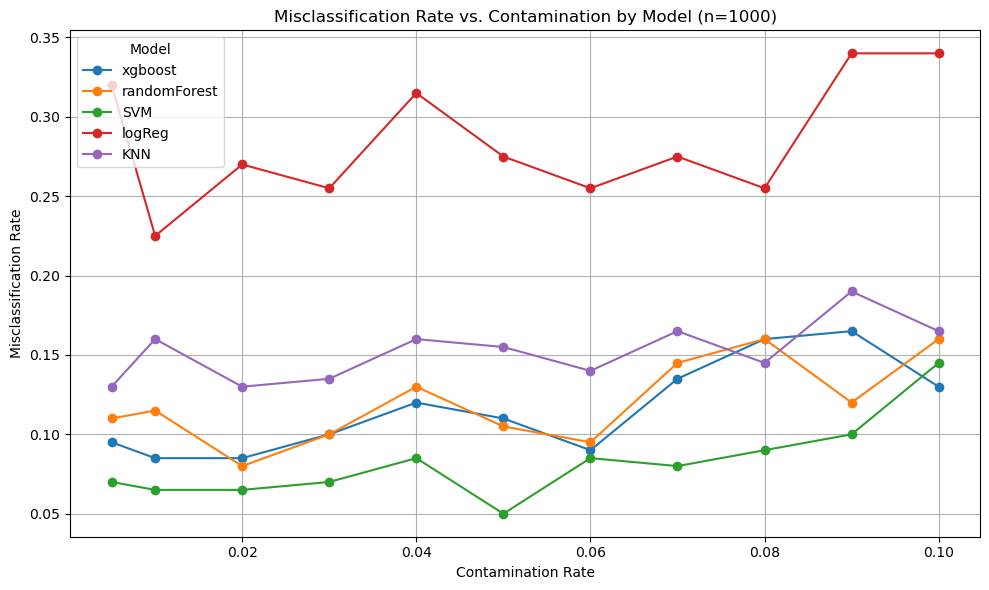

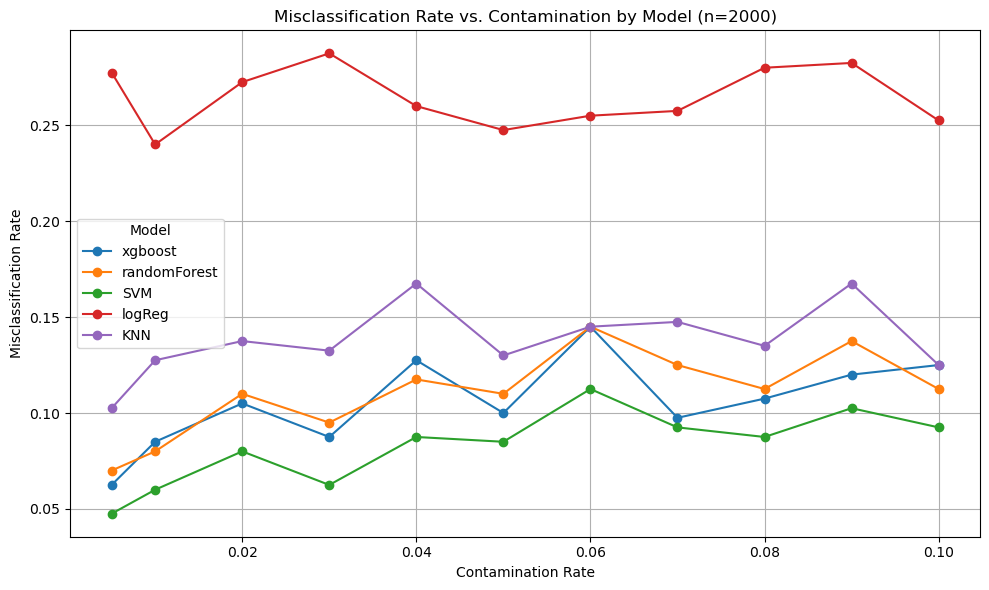

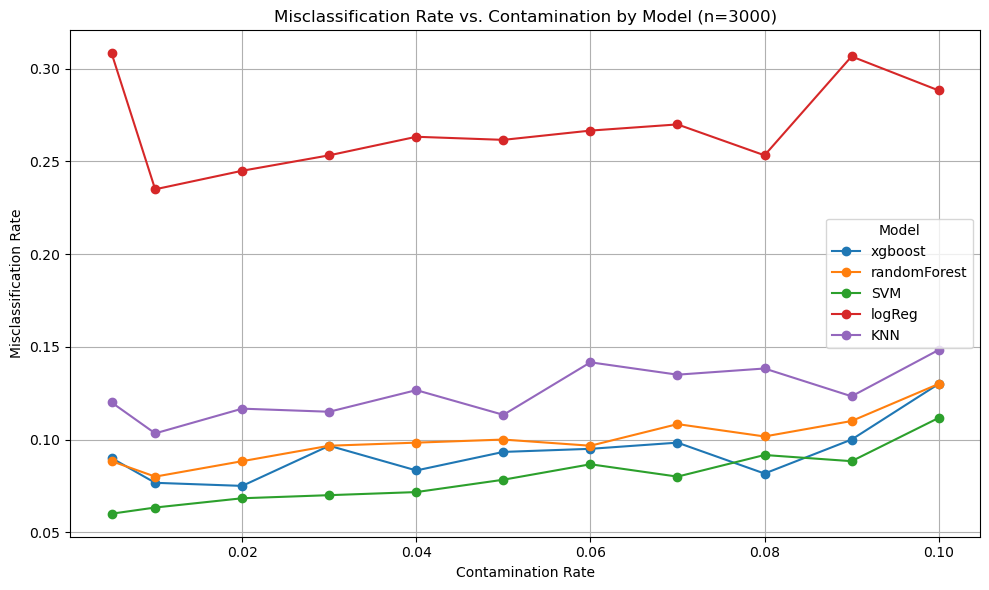

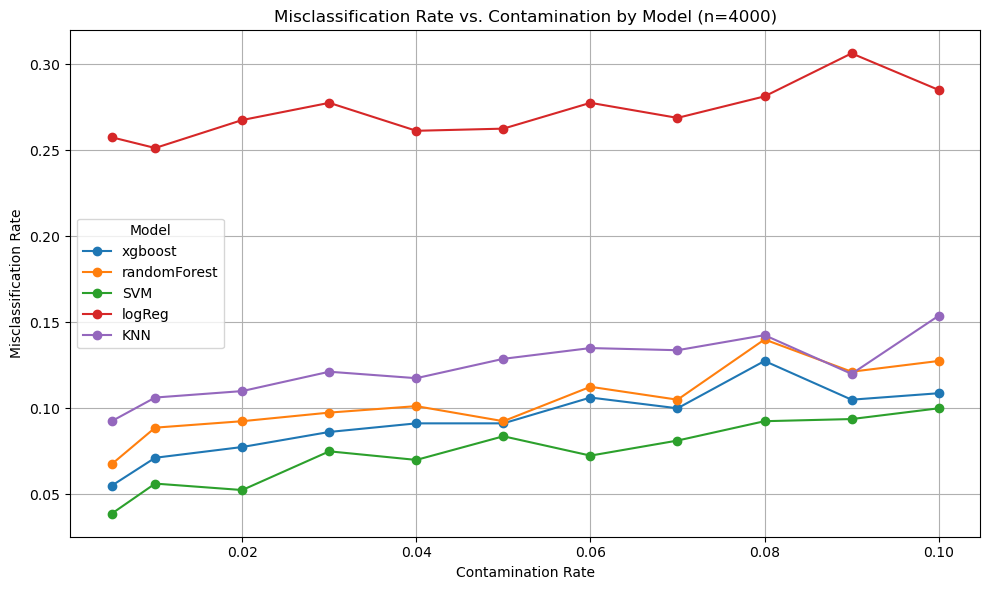

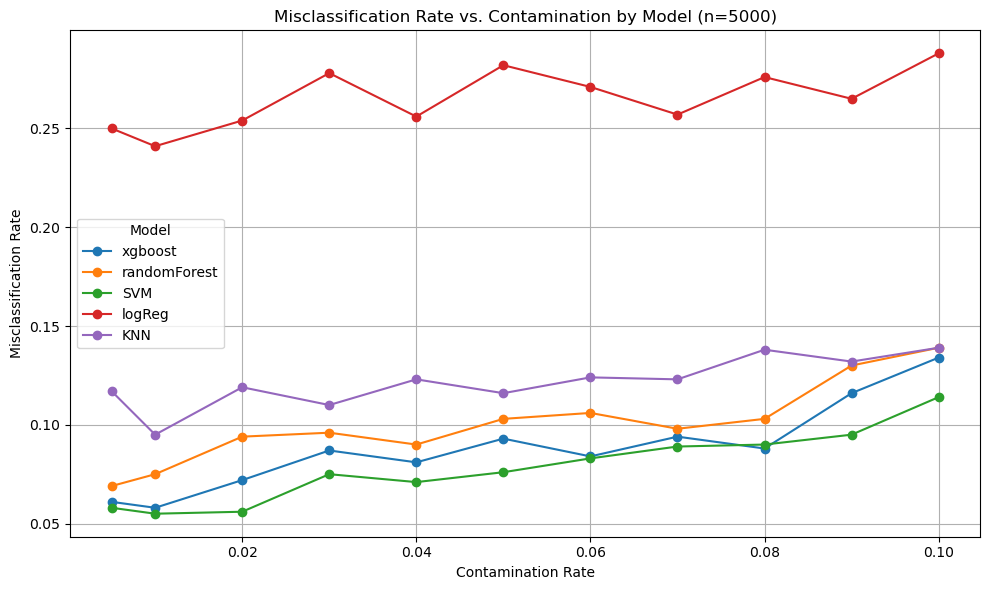

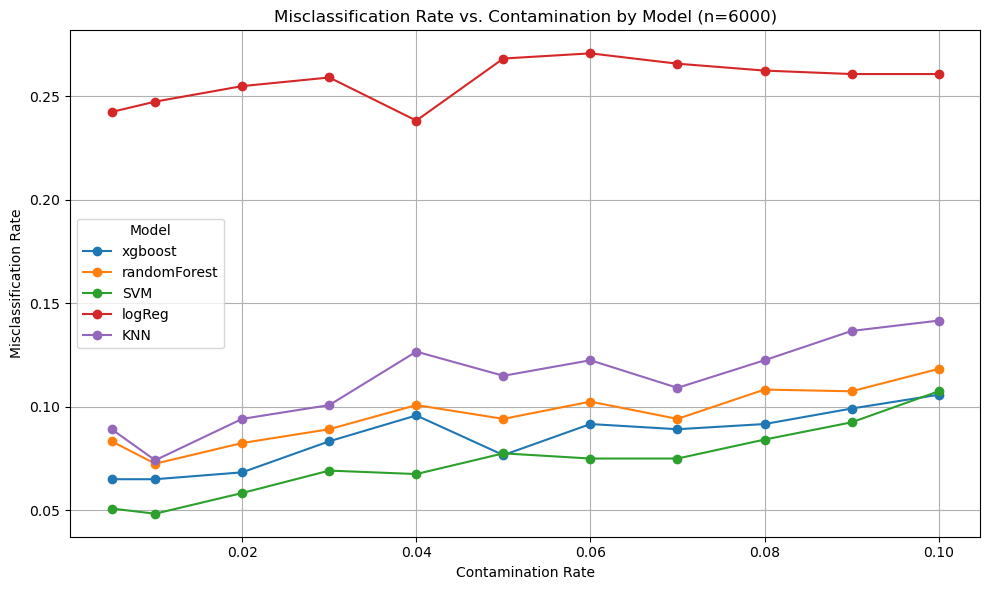

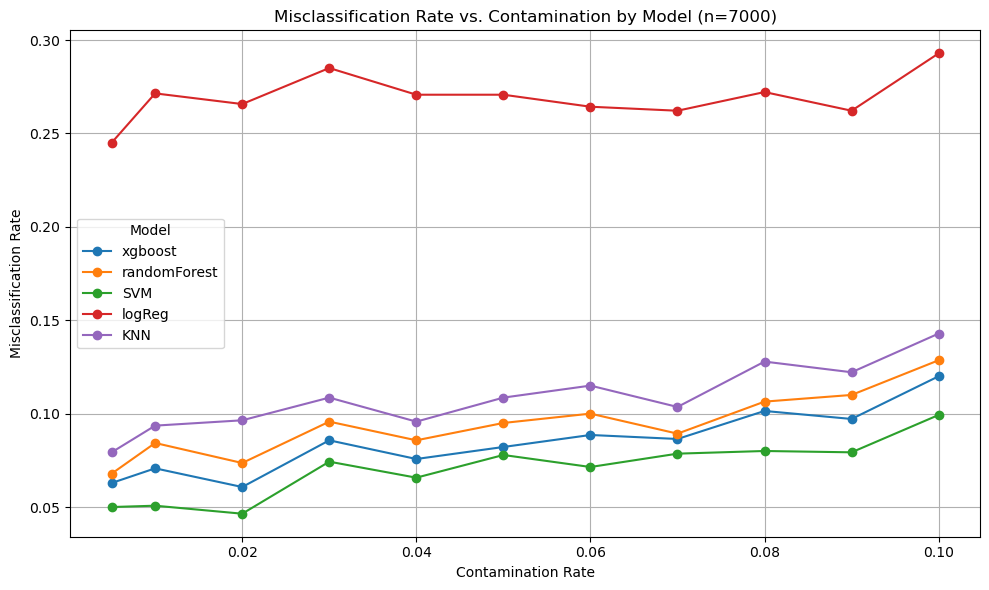

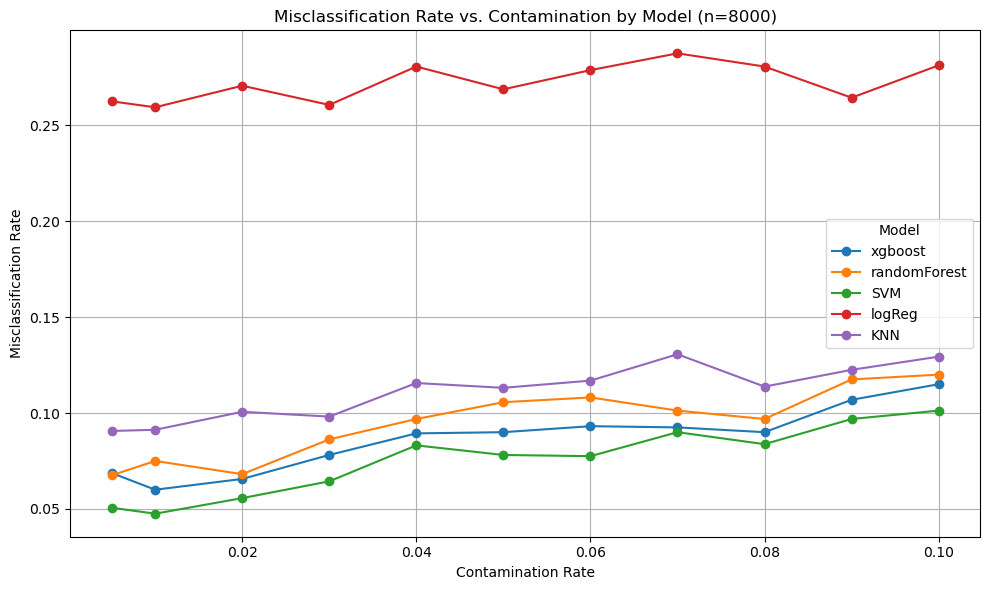

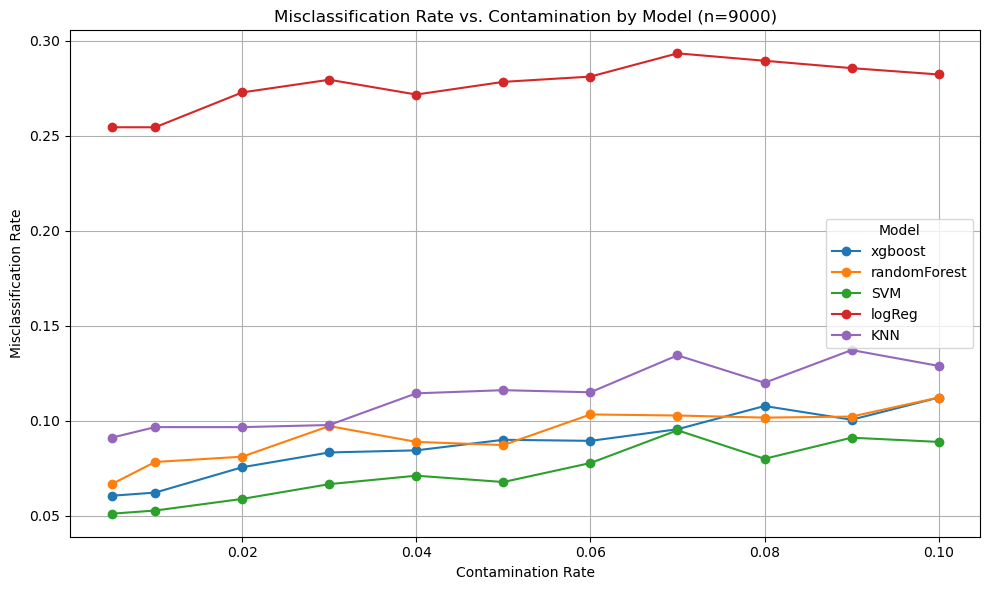

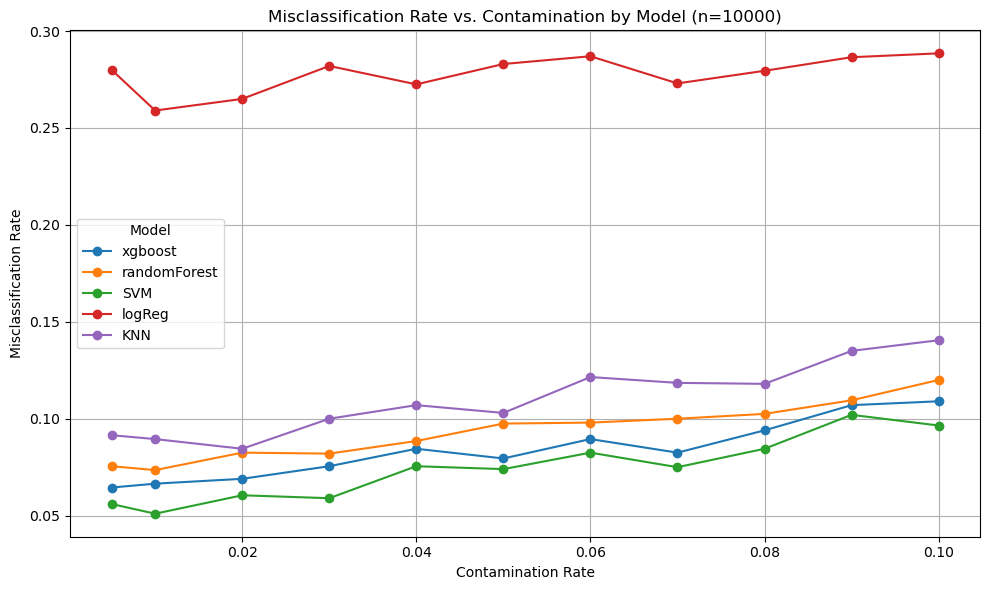

In [60]:
for n in sample_sizes:
    plot_misclass_contamination(accuracy_summary, n)